## Model Library, definition, Loading weights

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from tqdm import tqdm


In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(GraphSAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader, device):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj
                edge_index = edge_index.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x)
                pbar.update(batch_size)
            x_all = torch.cat(xs, dim=0)

        pbar.close()
        return x_all


In [9]:
#Now instantiate and load weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate the model architecture
model = GraphSAGE(in_channels=100, hidden_channels=256, out_channels=47, num_layers=3)
model.load_state_dict(torch.load('graphsage_model.pth', map_location=device))
model = model.to(device)
model.eval()


C:\Users\nurja\AppData\Local\Temp\ipykernel_28736\3746250163.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('graphsage_model.pth', map_

GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(100, 256, aggr=mean)
    (1): SAGEConv(256, 256, aggr=mean)
    (2): SAGEConv(256, 47, aggr=mean)
  )
)

## Prepare dataset

In [21]:
from ogb.nodeproppred import PygNodePropPredDataset

# Load dataset
root = 'home/data/products'  # or wherever your OGBN-Products data is
dataset = PygNodePropPredDataset(name='ogbn-products', root=root)
data = dataset[0]
split_idx = dataset.get_idx_split()

# Move node features to device
x = data.x.to(device)

y = data.y.squeeze().to(device)


c:\Users\nurja\anaconda3\lib\site-packages\torch_geometric\data\dataset.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(sel

## Prepare Subgraph Loader for Full Inference

In [11]:
from torch_geometric.data import NeighborSampler

subgraph_loader = NeighborSampler(
    data.edge_index,
    node_idx=None,      # all nodes
    sizes=[-1],         # use all neighbors
    batch_size=1024,    # you can adjust batch size (512, 2048 depending on your memory)
    shuffle=False
)


c:\Users\nurja\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


## Run Inference and Get Node Embeddings

In [27]:
@torch.no_grad()
def test(model, data, split_idx):
    model.eval()
    out = model.inference(data.x.to(device), subgraph_loader, device)
    y_pred = out.argmax(dim=-1, keepdim=True)
    y_true = y.cpu().unsqueeze(-1)
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']
    
    return test_acc, out


In [28]:



from ogb.nodeproppred import Evaluator
evaluator = Evaluator(name='ogbn-products')

In [29]:
test_acc, embeddings = test(model, data, split_idx)
print(f"Final Test Accuracy: {test_acc:.4f}")


Evaluating: 100%|██████████| 7347087/7347087 [02:46<00:00, 44148.31it/s]


Final Test Accuracy: 0.7876


##Visualize

c:\Users\nurja\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nurja\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


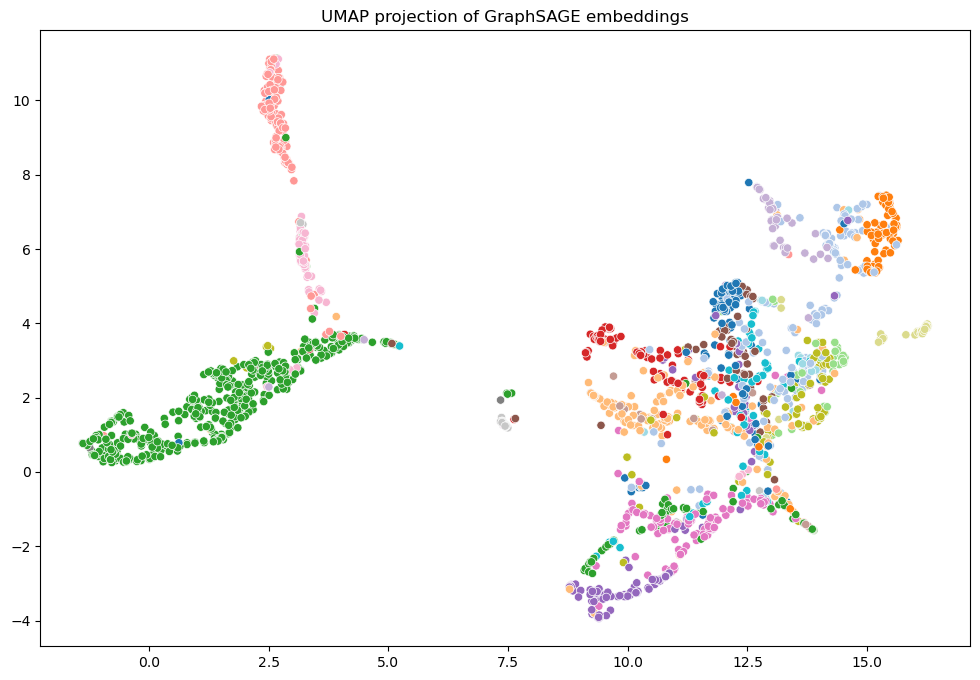

In [30]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Take a sample of 2000 nodes from test set
embedding_sample = embeddings[split_idx['test']][:2000].cpu().numpy()
labels_sample = data.y[split_idx['test']][:2000].cpu().numpy()

# UMAP Reduction
reducer = umap.UMAP()
embedding_2d = reducer.fit_transform(embedding_sample)

# Plot
plt.figure(figsize=(12,8))
sns.scatterplot(x=embedding_2d[:,0], y=embedding_2d[:,1], hue=labels_sample.squeeze(), palette='tab20', legend=False)
plt.title('UMAP projection of GraphSAGE embeddings')
plt.show()
